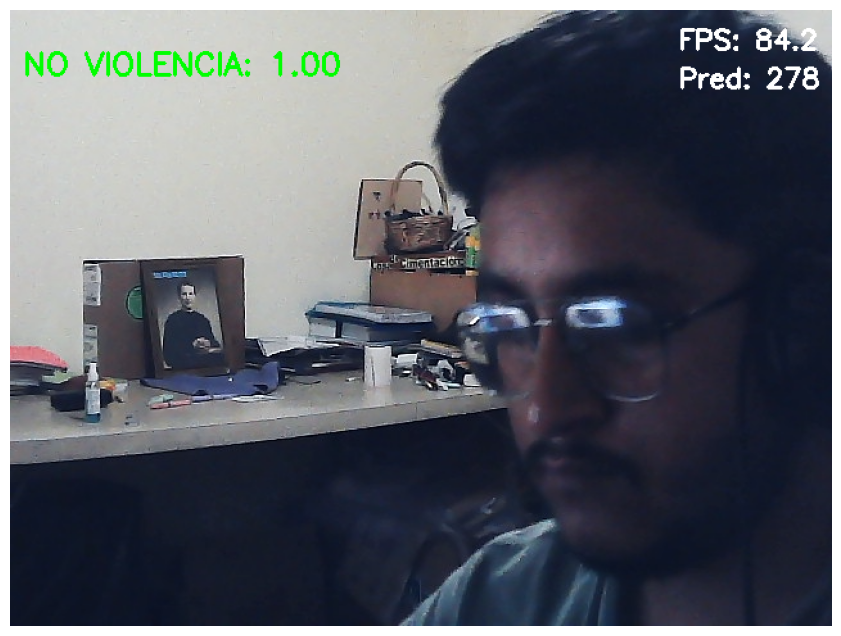


Estadísticas de rendimiento:
Tiempo total: 113.00 segundos
Frames procesados: 1395
FPS promedio: 12.34
Predicciones realizadas: 279


In [2]:
# Importar bibliotecas necesarias
import cv2
import numpy as np
from collections import deque
import time
import tensorflow as tf
import os
import datetime
import logging
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Definir parámetros globales (asegúrate de que coincidan con tu modelo)
IMAGE_HEIGHT, IMAGE_WIDTH = 96, 96  # Ajusta a tu resolución
SEQUENCE_LENGTH = 20  # Ajusta a tu secuencia
CLASSES_LIST = ["NonViolence", "Violence"]  # Tus clases

# Cargar el modelo entrenado
def load_model(model_path="../model/saved_models/violence_detection_model.h5"):
    """Carga el modelo entrenado desde el archivo"""
    print(f"Cargando modelo desde: {model_path}")
    model = tf.keras.models.load_model(model_path)
    print("Modelo cargado exitosamente")
    return model

# Función de detección en tiempo real
def detect_violence_webcam(model, threshold=0.6, camera_id=0, log_dir="logs", output_dir="violence_detections"):
    """
    Detecta violencia en tiempo real usando la webcam con registro y captura de evidencia
    
    Args:
        model: El modelo entrenado
        threshold: Umbral de confianza para detectar violencia
        camera_id: ID de la cámara a utilizar (0 para la webcam predeterminada)
        log_dir: Directorio para guardar los logs
        output_dir: Directorio para guardar las evidencias (fotos/videos)
    """
    # Crear directorios si no existen
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(output_dir, exist_ok=True)
    
    # Configurar logging
    logging.basicConfig(
        filename=os.path.join(log_dir, f"violence_detection_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.log"),
        level=logging.INFO,
        format='%(asctime)s - %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S'
    )
    
    # Inicializar la webcam
    cap = cv2.VideoCapture(camera_id)
    
    if not cap.isOpened():
        print("Error: No se pudo abrir la webcam.")
        logging.error("No se pudo abrir la webcam.")
        return
    
    # Ajustar la resolución para mejor rendimiento
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    
    # Obtener FPS de la cámara para calcular duración
    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps <= 0:
        fps = 30  # Valor por defecto si no se puede obtener
    
    # Cola para almacenar frames
    frames_queue = deque(maxlen=SEQUENCE_LENGTH)
    
    # Inicializar con frames vacíos
    for _ in range(SEQUENCE_LENGTH):
        frames_queue.append(np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=np.float32))
    
    # Variables para medición de rendimiento
    frame_count = 0
    prediction_count = 0
    start_time = time.time()
    fps_list = []
    
    # Variables para la predicción
    predicted_class = "Iniciando..."
    confidence = 0.0
    
    # Variables para seguimiento de violencia continua
    violence_start_time = None
    continuous_violence_duration = 0
    violence_frames_buffer = deque(maxlen=int(fps * 5))  # Guardar 5 segundos de frames
    is_recording = False
    video_writer = None
    
    print("Iniciando detección en tiempo real. Presiona 'q' para salir.")
    logging.info("Sistema de detección de violencia iniciado")
    
    while True:
        # Medir tiempo para cálculo de FPS
        frame_start_time = time.time()
        
        # Leer frame de la webcam
        ret, frame = cap.read()
        if not ret:
            print("Error al leer frame de la webcam.")
            logging.error("Error al leer frame de la webcam.")
            break
        
        # Incrementar contador
        frame_count += 1
        
        # Preprocesar frame
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255.0
        
        # Actualizar cola
        frames_queue.append(normalized_frame)
        
        # Realizar predicción cada cierto número de frames para mantener buen rendimiento
        if frame_count % 5 == 0:  # Predecir cada 5 frames
            prediction_count += 1
            prediction_start = time.time()
            
            # Preparar datos de entrada
            input_data = np.expand_dims(np.array(list(frames_queue)), axis=0)
            
            # Realizar predicción
            prediction = model.predict(input_data, verbose=0)[0]
            
            # Obtener clase y confianza
            predicted_idx = np.argmax(prediction)
            confidence = prediction[predicted_idx]
            predicted_class = CLASSES_LIST[predicted_idx]
            
            prediction_time = time.time() - prediction_start
        
        # Guardar el frame actual en el buffer si hay violencia (para guardar video)
        violence_frames_buffer.append(frame.copy())
        
        # Añadir información al frame
        current_time = time.time()
        
        if predicted_class == "Violence" and confidence >= threshold:
            # Registrar detección de violencia en el log
            if violence_start_time is None:
                violence_start_time = current_time
                logging.warning(f"Violencia detectada - Confianza: {confidence:.2f}")
                print(f"Violencia detectada - Confianza: {confidence:.2f}")
            
            # Calcular duración de violencia continua
            continuous_violence_duration = current_time - violence_start_time
            
            # Rojo para violencia
            color = (0, 0, 255)
            cv2.putText(frame, f"VIOLENCIA DETECTADA: {confidence:.2f}", (10, 50), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
            # Añadir borde rojo al frame
            cv2.rectangle(frame, (0, 0), (frame.shape[1], frame.shape[0]), color, 4)
            
            # Mostrar duración de la violencia
            cv2.putText(frame, f"Duración: {continuous_violence_duration:.1f}s", (10, 80),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
            
            # Si ha pasado 5 segundos de violencia continua, guardar evidencia
            if continuous_violence_duration >= 5.0 and not is_recording:
                # Guardar una foto
                timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
                photo_path = os.path.join(output_dir, f"violence_{timestamp}.jpg")
                cv2.imwrite(photo_path, frame)
                logging.info(f"Foto de violencia guardada: {photo_path}")
                print(f"Foto guardada: {photo_path}")
                
                # Iniciar grabación de video
                is_recording = True
                video_path = os.path.join(output_dir, f"violence_video_{timestamp}.mp4")
                fourcc = cv2.VideoWriter_fourcc(*'mp4v')
                video_writer = cv2.VideoWriter(
                    video_path, 
                    fourcc, 
                    fps, 
                    (frame.shape[1], frame.shape[0])
                )
                
                # Guardar los frames anteriores (buffer)
                for buffered_frame in violence_frames_buffer:
                    video_writer.write(buffered_frame)
                
                logging.info(f"Iniciando grabación de video: {video_path}")
                print(f"Iniciando grabación de video: {video_path}")
        else:
            # Verde para no violencia
            color = (0, 255, 0)
            cv2.putText(frame, f"NO VIOLENCIA: {confidence:.2f}", (10, 50), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
            
            # Resetear temporizador de violencia
            if violence_start_time is not None:
                logging.info(f"Fin de detección de violencia. Duración: {continuous_violence_duration:.1f}s")
                violence_start_time = None
                continuous_violence_duration = 0
            
            # Detener grabación si estaba activa
            if is_recording:
                is_recording = False
                if video_writer is not None:
                    video_writer.release()
                    logging.info("Grabación de video finalizada")
                    print("Grabación de video finalizada")
        
        # Si estamos grabando, añadir frame al video
        if is_recording and video_writer is not None:
            video_writer.write(frame)
        
        # Calcular y mostrar FPS
        frame_time = time.time() - frame_start_time
        fps_value = 1 / frame_time if frame_time > 0 else 0
        fps_list.append(fps_value)
        if len(fps_list) > 30:  # Mantener solo los últimos 30 valores para calcular promedio
            fps_list.pop(0)
        avg_fps = sum(fps_list) / len(fps_list)
        
        cv2.putText(frame, f"FPS: {avg_fps:.1f}", (frame.shape[1] - 120, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        # Mostrar contador de predicciones
        cv2.putText(frame, f"Pred: {prediction_count}", (frame.shape[1] - 120, 60), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        # Mostrar estado de grabación
        if is_recording:
            cv2.putText(frame, "REC", (10, frame.shape[0] - 20), 
                      cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            # Círculo rojo parpadeante para indicar grabación
            if int(time.time() * 2) % 2 == 0:  # Parpadeo cada 0.5 segundos
                cv2.circle(frame, (40, frame.shape[0] - 25), 8, (0, 0, 255), -1)
        
        # Mostrar frame
        cv2.imshow('Detección de Violencia en Tiempo Real', frame)
        
        # Actualizar la visualización en el notebook (opcional)
        # Esta parte solo funciona en algunos entornos de notebook
        if frame_count % 10 == 0:  # Actualizar cada 10 frames para no sobrecargar
            try:
                # Convertir de BGR a RGB para matplotlib
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                clear_output(wait=True)
                plt.figure(figsize=(12, 8))
                plt.imshow(frame_rgb)
                plt.axis('off')
                plt.show()
            except:
                pass  # Si falla, seguir con la visualización normal de OpenCV
        
        # Salir si se presiona 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Liberar recursos
    cap.release()
    if video_writer is not None:
        video_writer.release()
    cv2.destroyAllWindows()
    
    # Mostrar estadísticas
    total_time = time.time() - start_time
    stats_msg = f"\nEstadísticas de rendimiento:\n" \
                f"Tiempo total: {total_time:.2f} segundos\n" \
                f"Frames procesados: {frame_count}\n" \
                f"FPS promedio: {frame_count/total_time:.2f}\n" \
                f"Predicciones realizadas: {prediction_count}"
    
    print(stats_msg)
    logging.info(stats_msg)
    logging.info("Sistema de detección de violencia finalizado")

# Ejecutar la detección (descomenta estas líneas para usarlo)
if __name__ == "__main__":
    # Cargar modelo
    model = load_model("violence_detection_model.h5")  # Ajusta la ruta a tu modelo
    
    # Iniciar detección en tiempo real
    detect_violence_webcam(model, threshold=0.8, camera_id=0)